### 1. Query to extract client data

In [0]:
%sql
with base as (
  select 
    r.axa_party_id,
    r.policy_no,
    r.register_date,
    r.trmn_eff_date,
    r.wti_lob_txt,
    r.prod_lob,
    r.agt_class,
    r.isrd_brth_date,
    r.psn_age,
    r.acct_val_amt,
    r.face_amt,
    r.cash_val_amt,
    r.wc_total_assets,
    r.wc_assetmix_stocks,
    r.wc_assetmix_bonds,
    r.wc_assetmix_mutual_funds,
    r.wc_assetmix_annuity,
    r.wc_assetmix_deposits,
    r.wc_assetmix_other_assets,
    r.division_name,
    r.mkt_prod_hier,
    r.policy_status,
    r.agent_segment,
    r.channel,
    r.client_seg,
    r.client_seg_1,
    r.aum_band,
    r.business_month,
    r.branchoffice_code,
    r.agt_no,
    h.sub_product_level_1,
    h.sub_product_level_2,
    h.Product,
    row_number() over (partition by r.axa_party_id order by r.register_date asc) as rn,
    row_number() over (partition by r.axa_party_id order by r.register_date asc) = 1 as is_first_policy
  from dl_tenants_daas.us_wealth_management.wealth_management_client_metrics r
  left join (
    select distinct source_sys_id, idb_plan_cd, idb_sub_plan_cd, 
      trim(stmt_plan_typ_txt) as Product, sub_product_level_1, sub_product_level_2
    from dl_tenants_daas.us_wealth_management.wealth_management_sub_product_group
  ) h 
    on upper(r.source_sys_id) = upper(h.source_sys_id)
    and trim(upper(REPLACE(LTRIM(REPLACE(r.plan_code,'0',' ')),' ','0'))) = trim(upper(h.idb_plan_cd))
    and trim(upper(REPLACE(LTRIM(REPLACE(r.plan_subcd_code,'0',' ')),' ','0'))) = trim(upper(h.idb_sub_plan_cd))
  where r.business_month = (select max(business_month) from dl_tenants_daas.us_wealth_management.wealth_management_client_metrics)
    and r.axa_party_id is not null
    and r.policy_no is not null
),
first_second as (
  select
    axa_party_id,
    -- First policy fields
    max(case when rn = 1 then policy_no end) as policy_no,
    max(case when rn = 1 then register_date end) as register_date,
    max(case when rn = 1 then trmn_eff_date end) as trmn_eff_date,
    max(case when rn = 1 then wti_lob_txt end) as wti_lob_txt,
    max(case when rn = 1 then prod_lob end) as prod_lob,
    max(case when rn = 1 then agt_class end) as agt_class,
    max(case when rn = 1 then isrd_brth_date end) as isrd_brth_date,
    max(case when rn = 1 then psn_age end) as psn_age,
    max(case when rn = 1 then acct_val_amt end) as acct_val_amt,
    max(case when rn = 1 then face_amt end) as face_amt,
    max(case when rn = 1 then cash_val_amt end) as cash_val_amt,
    max(case when rn = 1 then wc_total_assets end) as wc_total_assets,
    max(case when rn = 1 then wc_assetmix_stocks end) as wc_assetmix_stocks,
    max(case when rn = 1 then wc_assetmix_bonds end) as wc_assetmix_bonds,
    max(case when rn = 1 then wc_assetmix_mutual_funds end) as wc_assetmix_mutual_funds,
    max(case when rn = 1 then wc_assetmix_annuity end) as wc_assetmix_annuity,
    max(case when rn = 1 then wc_assetmix_deposits end) as wc_assetmix_deposits,
    max(case when rn = 1 then wc_assetmix_other_assets end) as wc_assetmix_other_assets,
    max(case when rn = 1 then client_seg end) as client_seg,
    max(case when rn = 1 then client_seg_1 end) as client_seg_1,
    max(case when rn = 1 then aum_band end) as aum_band,
    max(case when rn = 1 then sub_product_level_1 end) as sub_product_level_1,
    max(case when rn = 1 then sub_product_level_2 end) as sub_product_level_2,
    max(case when rn = 1 then Product end) as Product,
    max(case when rn = 1 then business_month end) as business_month,
    max(case when rn = 1 then branchoffice_code end) as branchoffice_code,
    max(case when rn = 1 then agt_no end) as agt_no,
    max(case when rn = 1 then division_name end) as division_name,
    max(case when rn = 1 then mkt_prod_hier end) as mkt_prod_hier,
    max(case when rn = 1 then policy_status end) as policy_status ,
    max(case when rn = 1 then channel end) as channel,
    max(case when rn = 1 then agent_segment end) as agent_segment,
    -- Second policy fields
    max(case when rn = 2 then policy_no end) as second_policy_no,
    max(case when rn = 2 then register_date end) as second_register_date,
    max(case when rn = 2 then trmn_eff_date end) as second_trmn_eff_date,
    max(case when rn = 2 then wti_lob_txt end) as second_wti_lob_txt,
    max(case when rn = 2 then prod_lob end) as second_prod_lob,
    max(case when rn = 2 then sub_product_level_1 end) as second_sub_product_level_1,
    max(case when rn = 2 then sub_product_level_2 end) as second_sub_product_level_2,
    max(case when rn = 2 then Product end) as second_Product
  from base
  where rn <= 2
  group by axa_party_id
)
select *,
  wc_assetmix_stocks / NULLIF(wc_total_assets, 0) AS stock_allocation_ratio,
  wc_assetmix_bonds / NULLIF(wc_total_assets, 0) AS bond_allocation_ratio,
  wc_assetmix_annuity / NULLIF(wc_total_assets, 0) AS annuity_allocation_ratio,
  wc_assetmix_mutual_funds / NULLIF(wc_total_assets, 0) AS mutual_fund_allocation_ratio,
  acct_val_amt / NULLIF(wc_total_assets, 0) AS aum_to_asset_ratio,
  face_amt / NULLIF(wc_total_assets, 0) AS policy_value_to_assets_ratio,
  
  CASE 
    WHEN prod_lob = 'LIFE' THEN 'LIFE_INSURANCE'
    WHEN sub_product_level_1 IN ('VLI', 'WL', 'UL/IUL', 'TERM', 'PROTECTIVE PRODUCT') THEN 'LIFE_INSURANCE'
    WHEN sub_product_level_2 LIKE '%LIFE%' THEN 'LIFE_INSURANCE'
    WHEN sub_product_level_2 IN ('VARIABLE UNIVERSAL LIFE', 'WHOLE LIFE', 'UNIVERSAL LIFE', 
                                'INDEX UNIVERSAL LIFE', 'TERM PRODUCT', 'VARIABLE LIFE', 
                                'SURVIVORSHIP WHOLE LIFE', 'MONY PROTECTIVE PRODUCT') THEN 'LIFE_INSURANCE'
    WHEN prod_lob IN ('GROUP RETIREMENT', 'INDIVIDUAL RETIREMENT') THEN 'RETIREMENT'
    WHEN sub_product_level_1 IN ('EQUIVEST', 'RETIREMENT 401K', 'ACCUMULATOR', 
                                'RETIREMENT CORNERSTONE', 'SCS', 'INVESTMENT EDGE') THEN 'RETIREMENT'
    WHEN sub_product_level_2 LIKE '%403B%' OR sub_product_level_2 LIKE '%401%' 
         OR sub_product_level_2 LIKE '%IRA%' OR sub_product_level_2 LIKE '%SEP%' THEN 'RETIREMENT'
    WHEN Product LIKE '%IRA%' OR Product LIKE '%401%' OR Product LIKE '%403%' 
         OR Product LIKE '%SEP%' OR Product LIKE '%Accumulator%' 
         OR Product LIKE '%Retirement%' THEN 'RETIREMENT'
    WHEN prod_lob = 'BROKER DEALER' THEN 'INVESTMENT'
    WHEN sub_product_level_1 IN ('INVESTMENT PRODUCT - DIRECT', 'INVESTMENT PRODUCT - BROKERAGE', 
                                'INVESTMENT PRODUCT - ADVISORY', 'DIRECT', 'BROKERAGE', 
                                'ADVISORY', 'CASH SOLICITOR') THEN 'INVESTMENT'
    WHEN sub_product_level_2 LIKE '%Investment%' OR sub_product_level_2 LIKE '%Brokerage%' 
         OR sub_product_level_2 LIKE '%Advisory%' THEN 'INVESTMENT'
    WHEN prod_lob = 'NETWORK' THEN 'NETWORK_PRODUCTS'
    WHEN sub_product_level_1 = 'NETWORK PRODUCTS' OR sub_product_level_2 = 'NETWORK PRODUCTS' THEN 'NETWORK_PRODUCTS'
    WHEN Product LIKE '%Network%' THEN 'NETWORK_PRODUCTS'
    WHEN prod_lob = 'OTHERS' AND sub_product_level_1 = 'HAS' THEN 'DISABILITY'
    WHEN sub_product_level_2 = 'HAS - DISABILITY' THEN 'DISABILITY'
    WHEN Product LIKE '%Disability%' OR Product LIKE '%DI -%' THEN 'DISABILITY'
    WHEN prod_lob = 'OTHERS' THEN 'HEALTH'
    WHEN sub_product_level_2 = 'GROUP HEALTH PRODUCTS' THEN 'HEALTH'
    WHEN Product LIKE '%Health%' OR Product LIKE '%Medical%' OR Product LIKE '%Hospital%' THEN 'HEALTH'
    ELSE 'OTHER'
  END AS product_category,
  CASE 
    WHEN second_prod_lob IS NULL THEN NULL
    WHEN second_prod_lob = 'LIFE' THEN 'LIFE_INSURANCE'
    WHEN second_sub_product_level_1 IN ('VLI', 'WL', 'UL/IUL', 'TERM', 'PROTECTIVE PRODUCT') THEN 'LIFE_INSURANCE'
    WHEN second_sub_product_level_2 LIKE '%LIFE%' THEN 'LIFE_INSURANCE'
    WHEN second_sub_product_level_2 IN ('VARIABLE UNIVERSAL LIFE', 'WHOLE LIFE', 'UNIVERSAL LIFE', 
                                'INDEX UNIVERSAL LIFE', 'TERM PRODUCT', 'VARIABLE LIFE', 
                                'SURVIVORSHIP WHOLE LIFE', 'MONY PROTECTIVE PRODUCT') THEN 'LIFE_INSURANCE'
    WHEN second_prod_lob IN ('GROUP RETIREMENT', 'INDIVIDUAL RETIREMENT') THEN 'RETIREMENT'
    WHEN second_sub_product_level_1 IN ('EQUIVEST', 'RETIREMENT 401K', 'ACCUMULATOR', 
                                'RETIREMENT CORNERSTONE', 'SCS', 'INVESTMENT EDGE') THEN 'RETIREMENT'
    WHEN second_sub_product_level_2 LIKE '%403B%' OR second_sub_product_level_2 LIKE '%401%' 
         OR second_sub_product_level_2 LIKE '%IRA%' OR second_sub_product_level_2 LIKE '%SEP%' THEN 'RETIREMENT'
    WHEN second_Product LIKE '%IRA%' OR second_Product LIKE '%401%' OR second_Product LIKE '%403%' 
         OR second_Product LIKE '%SEP%' OR second_Product LIKE '%Accumulator%' 
         OR second_Product LIKE '%Retirement%' THEN 'RETIREMENT'
    WHEN second_prod_lob = 'BROKER DEALER' THEN 'INVESTMENT'
    WHEN second_sub_product_level_1 IN ('INVESTMENT PRODUCT - DIRECT', 'INVESTMENT PRODUCT - BROKERAGE', 
                                'INVESTMENT PRODUCT - ADVISORY', 'DIRECT', 'BROKERAGE', 
                                'ADVISORY', 'CASH SOLICITOR') THEN 'INVESTMENT'
    WHEN second_sub_product_level_2 LIKE '%Investment%' OR second_sub_product_level_2 LIKE '%Brokerage%' 
         OR second_sub_product_level_2 LIKE '%Advisory%' THEN 'INVESTMENT'
    WHEN second_prod_lob = 'NETWORK' THEN 'NETWORK_PRODUCTS'
    WHEN second_sub_product_level_1 = 'NETWORK PRODUCTS' OR second_sub_product_level_2 = 'NETWORK PRODUCTS' THEN 'NETWORK_PRODUCTS'
    WHEN second_Product LIKE '%Network%' THEN 'NETWORK_PRODUCTS'
    WHEN second_prod_lob = 'OTHERS' AND second_sub_product_level_1 = 'HAS' THEN 'DISABILITY'
    WHEN second_sub_product_level_2 = 'HAS - DISABILITY' THEN 'DISABILITY'
    WHEN second_Product LIKE '%Disability%' OR second_Product LIKE '%DI -%' THEN 'DISABILITY'
    WHEN second_prod_lob = 'OTHERS' THEN 'HEALTH'
    WHEN second_sub_product_level_2 = 'GROUP HEALTH PRODUCTS' THEN 'HEALTH'
    WHEN second_Product LIKE '%Health%' OR second_Product LIKE '%Medical%' OR second_Product LIKE '%Hospital%' THEN 'HEALTH'
    ELSE 'OTHER'
  END AS second_product_category,
  CASE
    WHEN MONTH(register_date) BETWEEN 1 AND 3 THEN 'Q1'
    WHEN MONTH(register_date) BETWEEN 4 AND 6 THEN 'Q2'
    WHEN MONTH(register_date) BETWEEN 7 AND 9 THEN 'Q3'
    WHEN MONTH(register_date) BETWEEN 10 AND 12 THEN 'Q4'
    ELSE 'Unknown'
  END AS season_of_first_policy
  
from first_second

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = _sqldf.toPandas()

# age at first policy (calculated from dates)
df['register_date'] = pd.to_datetime(df['register_date'], errors='coerce')
df['isrd_brth_date'] = pd.to_datetime(df['isrd_brth_date'], errors='coerce')
df['age_at_first_policy'] = (df['register_date'] - df['isrd_brth_date']).dt.days / 365.25

# age at second policy
df['second_register_date'] = pd.to_datetime(df['second_register_date'], errors='coerce')
df['age_at_second_policy'] = (df['second_register_date'] - df['isrd_brth_date']).dt.days / 365.25

# time gap between first and second policy
df['years_to_second'] = (df['second_register_date'] - df['register_date']).dt.days / 365.25


In [0]:
display(df.head(5))

axa_party_id,policy_no,register_date,trmn_eff_date,wti_lob_txt,prod_lob,agt_class,isrd_brth_date,psn_age,acct_val_amt,face_amt,cash_val_amt,wc_total_assets,wc_assetmix_stocks,wc_assetmix_bonds,wc_assetmix_mutual_funds,wc_assetmix_annuity,wc_assetmix_deposits,wc_assetmix_other_assets,client_seg,client_seg_1,aum_band,sub_product_level_1,sub_product_level_2,Product,business_month,branchoffice_code,agt_no,division_name,mkt_prod_hier,policy_status,channel,agent_segment,second_policy_no,second_register_date,second_trmn_eff_date,second_wti_lob_txt,second_prod_lob,second_sub_product_level_1,second_sub_product_level_2,second_Product,stock_allocation_ratio,bond_allocation_ratio,annuity_allocation_ratio,mutual_fund_allocation_ratio,aum_to_asset_ratio,policy_value_to_assets_ratio,product_category,second_product_category,season_of_first_policy,age_at_first_policy,age_at_second_policy,years_to_second
00BK05RY276VO5F4XXXX,011635841,1943-03-01T00:00:00.000Z,null,Life Insurance,LIFE,ESF - EXPERIENCED SALESFORCE,1937-07-12T00:00:00.000Z,88.0,3943.0,1000.0,3943.0,202320.0,33245.0,1083.0,53783.0,12489.0,100080.0,1640.0,200-399k,Strategic Spenders,<$25K,WL,Whole Life,Life Paid-Up Whole Life,202510,83,112582,Division 8,Individual,Active,Branch Assist,Generalist,null,null,null,null,null,null,null,null,0.16431890075128508,0.005352906287069988,0.06172894424673784,0.2658313562672993,0.01948892843020957,0.0049426650850138395,LIFE_INSURANCE,null,Q1,5.634496919917864,null,null
00BK05RY287CY5V7XXXX,013575860,1951-10-18T00:00:00.000Z,null,Life Insurance,LIFE,NON CAREER AGENTS,1934-06-11T00:00:00.000Z,91.0,15990.0,2000.0,15990.0,2068354.0,799767.0,79709.0,763990.0,67436.0,308563.0,48889.0,1-2.99m,Life Legacies,<$25K,WL,Whole Life,Twenty Payment Life,202510,173,097952,Southeast Complex,Individual,Active,Retail,Generalist,null,null,null,null,null,null,null,null,0.38666833627125724,0.03853740703960734,0.032603703234552694,0.36937100709066245,0.007730784962342036,9.669524655837444E-4,LIFE_INSURANCE,null,Q4,17.352498288843258,null,null
00BK05RY28JZ21Z8XXXX,014157974,1953-09-09T00:00:00.000Z,null,Life Insurance,LIFE,ESF - EXPERIENCED SALESFORCE,1944-09-28T00:00:00.000Z,81.0,896.0,1000.0,896.0,308589.0,31323.0,440.0,56344.0,17575.0,199339.0,3568.0,200-399k,Strategic Spenders,<$25K,WL,Whole Life,Twenty Payment Life,202510,83,112582,Division 8,Individual,Active,Branch Assist,Generalist,null,null,null,null,null,null,null,null,0.10150394213662833,0.0014258447319897987,0.05695277537436526,0.18258589904371186,0.002903538363324681,0.0032405562090677244,LIFE_INSURANCE,null,Q3,8.947296372347708,null,null
00BK05RY290NRYCGXXXX,014016911,1953-03-15T00:00:00.000Z,2024-10-09,Life Insurance,LIFE,NON CAREER AGENTS,1926-09-17T00:00:00.000Z,99.0,0.0,3000.0,0.0,227359.96,45936.42,3630.31,92854.07,15590.77,64804.15,4544.23,200-399k,Strategic Spenders,<$25K,WL,Whole Life,Ordinary Life,202510,572,097975,Mid Atlantic Complex,Individual,Inactive,Retail,Generalist,014817132,1955-08-03T00:00:00.000Z,null,Life Insurance,LIFE,WL,Whole Life,Twenty Payment Life,0.20204269916303644,0.01596723539184296,0.06857306801074385,0.4084011538355303,0.0,0.01319493546708928,LIFE_INSURANCE,LIFE_INSURANCE,Q1,26.491444216290212,28.876112251882272,2.3846680355920604
00BK05RY29CCVWR9XXXX,015428023,1957-02-13T00:00:00.000Z,null,Life Insurance,LIFE,ESF - EXPERIENCED SALESFORCE,1957-01-17T00:00:00.000Z,69.0,1726.0,1000.0,1726.0,852038.0,108432.0,8730.0,374614.0,82524.0,269311.0,8427.0,400-999k,Next Chapters,<$25K,WL,Whole Life,Twenty Payment Life,202510,83,112582,Division 8,Individual,Active,Branch Assist,Generalist,null,null,null,null,null,null,null,null,0.12726192963224645,0.010246021891042418,0.09685483511298792,0.439668183813398,0.002025731246728432,0.001173656574002568,LIFE_INSURANCE,null,Q1,0.07392197125256673,null,null


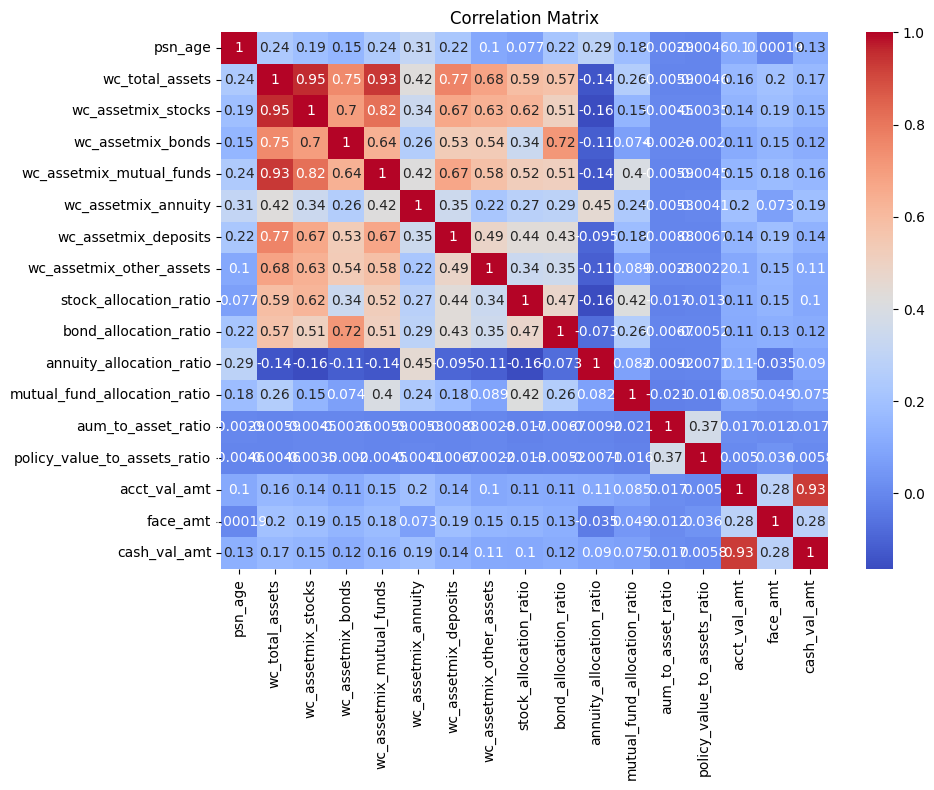

In [0]:
# Correlation matrix

numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
exclude_cols = ['years_to_second', 'days_to_second', 'age_at_first_policy', 'age_at_second_policy']
numerical_features = [col for col in numerical_features if col not in exclude_cols]

for col in ['acct_val_amt', 'face_amt', 'cash_val_amt']:
    if col in df.columns and col not in numerical_features:
        numerical_features = list(numerical_features) + [col]


### **DATA CLEANING**

In [0]:
display(df.columns)

Index(['axa_party_id', 'policy_no', 'register_date', 'trmn_eff_date',
       'wti_lob_txt', 'prod_lob', 'agt_class', 'isrd_brth_date', 'psn_age',
       'acct_val_amt', 'face_amt', 'cash_val_amt', 'wc_total_assets',
       'wc_assetmix_stocks', 'wc_assetmix_bonds', 'wc_assetmix_mutual_funds',
       'wc_assetmix_annuity', 'wc_assetmix_deposits',
       'wc_assetmix_other_assets', 'client_seg', 'client_seg_1', 'aum_band',
       'sub_product_level_1', 'sub_product_level_2', 'Product',
       'business_month', 'branchoffice_code', 'agt_no', 'division_name',
       'mkt_prod_hier', 'policy_status', 'channel', 'agent_segment',
       'second_policy_no', 'second_register_date', 'second_trmn_eff_date',
       'second_wti_lob_txt', 'second_prod_lob', 'second_sub_product_level_1',
       'second_sub_product_level_2', 'second_Product',
       'stock_allocation_ratio', 'bond_allocation_ratio',
       'annuity_allocation_ratio', 'mutual_fund_allocation_ratio',
       'aum_to_asset_ratio', 'policy

Dropping duplicates is important in ML to prevent data leakage, reduce bias, and ensure the model does not overfit to repeated samples.

In [0]:
# Remove duplicate rows
df = df.drop_duplicates()


Handle missing values - missing values in critical features can lead to unreliable model training, errors during fitting, or biased results.
Removing such rows ensures data quality and model integrity.

Separating numerical and categorical columns.



In [0]:
# Handle missing values

# drop rows with missing target or critical features
critical_cols = ['product_category']
df = df.dropna(subset=critical_cols)

num_cols = df.select_dtypes(include=['float64', 'int64']).columns
display(num_cols)

cat_cols = df.select_dtypes(include=['object']).columns
display(cat_cols)

Index(['psn_age', 'wc_total_assets', 'wc_assetmix_stocks', 'wc_assetmix_bonds',
       'wc_assetmix_mutual_funds', 'wc_assetmix_annuity',
       'wc_assetmix_deposits', 'wc_assetmix_other_assets',
       'stock_allocation_ratio', 'bond_allocation_ratio',
       'annuity_allocation_ratio', 'mutual_fund_allocation_ratio',
       'aum_to_asset_ratio', 'policy_value_to_assets_ratio',
       'age_at_first_policy', 'age_at_second_policy', 'years_to_second'],
      dtype='object')

Index(['axa_party_id', 'policy_no', 'trmn_eff_date', 'wti_lob_txt', 'prod_lob',
       'agt_class', 'client_seg', 'client_seg_1', 'aum_band',
       'sub_product_level_1', 'sub_product_level_2', 'Product',
       'branchoffice_code', 'agt_no', 'division_name', 'mkt_prod_hier',
       'policy_status', 'channel', 'agent_segment', 'second_policy_no',
       'second_trmn_eff_date', 'second_wti_lob_txt', 'second_prod_lob',
       'second_sub_product_level_1', 'second_sub_product_level_2',
       'second_Product', 'product_category', 'second_product_category',
       'season_of_first_policy'],
      dtype='object')

In [0]:
import scipy.stats as stats
import numpy as np

# List of financial columns
financial_cols = [col for col in df.columns if col.startswith('wc_')] + ['face_amt', 'cash_val_amt', 'acct_val_amt']
financial_cols = [col for col in financial_cols if col in df.columns]

# Compute skewness for each financial column
skewness_dict = {col: stats.skew(df[col].dropna()) for col in financial_cols}
skew_df = pd.DataFrame([skewness_dict])
display(skew_df)

# Apply log1p transformation to reduce skewness
for col in financial_cols:
    df[f'log_{col}'] = np.log1p(df[col])

# Compute skewness for each log-transformed financial column
log_skewness_dict = {f'log_{col}': stats.skew(df[f'log_{col}'].dropna()) for col in financial_cols}
log_skew_df = pd.DataFrame([log_skewness_dict])
display(log_skew_df)

wc_total_assets,wc_assetmix_stocks,wc_assetmix_bonds,wc_assetmix_mutual_funds,wc_assetmix_annuity,wc_assetmix_deposits,wc_assetmix_other_assets,face_amt,cash_val_amt,acct_val_amt
4.08634499415451,5.426911578366013,15.679434305597216,4.440412142368163,17.826015942846972,7.111353238054384,26.377674115574663,53.31286874305497,40.50468430702235,35.92179677587274


/databricks/python/lib/python3.12/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/databricks/python/lib/python3.12/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/databricks/python/lib/python3.12/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


log_wc_total_assets,log_wc_assetmix_stocks,log_wc_assetmix_bonds,log_wc_assetmix_mutual_funds,log_wc_assetmix_annuity,log_wc_assetmix_deposits,log_wc_assetmix_other_assets,log_face_amt,log_cash_val_amt,log_acct_val_amt
-3.367337621230025,-1.7649898832555317,-0.923430199287643,-2.097734626521522,-1.8956302655056925,-4.9065056441033486,-1.1477874546082587,-1.3141103813619393,0.6445987022520583,-0.6954772374707812


Standardizing date columns ensures all date fields are in a consistent datetime format,
which is necessary for reliable feature engineering (e.g., calculating durations, extracting year/month).

Removing outliers in numerical features (e.g., age_at_first_policy) prevents extreme values from distracting the model during training,
leading to more robust and generalizable models.


In [0]:
# Standardize date columns
date_cols = ['register_date', 'second_register_date', 'isrd_brth_date', 'trmn_eff_date', 'second_trmn_eff_date']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Remove outliers in numerical features
df = df[(df['age_at_first_policy'] >= 0) & (df['age_at_first_policy'] <= 100)]

# Categorical encoding (LabelEncoder is correct for tree models, but for Spark MLlib, use StringIndexer)
cat_cols = [
    'product_category', 'prod_lob', 'client_seg', 'aum_band', 'agt_class', 'season_of_first_policy', 'client_seg_1', 'division_name','mkt_prod_hier', 'policy_status', 'channel', 'agent_segment']
for col in cat_cols + ['second_product_category']:
    if col in df.columns:
        df[col] = df[col].astype(str)


In [0]:
df.columns

Index(['axa_party_id', 'policy_no', 'register_date', 'trmn_eff_date',
       'wti_lob_txt', 'prod_lob', 'agt_class', 'isrd_brth_date', 'psn_age',
       'acct_val_amt', 'face_amt', 'cash_val_amt', 'wc_total_assets',
       'wc_assetmix_stocks', 'wc_assetmix_bonds', 'wc_assetmix_mutual_funds',
       'wc_assetmix_annuity', 'wc_assetmix_deposits',
       'wc_assetmix_other_assets', 'client_seg', 'client_seg_1', 'aum_band',
       'sub_product_level_1', 'sub_product_level_2', 'Product',
       'business_month', 'branchoffice_code', 'agt_no', 'division_name',
       'mkt_prod_hier', 'policy_status', 'channel', 'agent_segment',
       'second_policy_no', 'second_register_date', 'second_trmn_eff_date',
       'second_wti_lob_txt', 'second_prod_lob', 'second_sub_product_level_1',
       'second_sub_product_level_2', 'second_Product',
       'stock_allocation_ratio', 'bond_allocation_ratio',
       'annuity_allocation_ratio', 'mutual_fund_allocation_ratio',
       'aum_to_asset_ratio', 'policy

Dropping highly correlated numerical features is important because:
1. It reduces multicollinearity, which can negatively impact model interpretability and stability.
2. It prevents redundant information, making models more efficient and less prone to overfitting.
3. It improves training speed and can enhance generalization by reducing noise from duplicate signals.


In [0]:
df = df.drop(columns=[
    'log_wc_assetmix_stocks',
    'log_wc_assetmix_bonds',
    'log_wc_assetmix_mutual_funds',
    'log_wc_assetmix_deposits',
    'log_wc_assetmix_other_assets',
    'log_acct_val_amt'
])

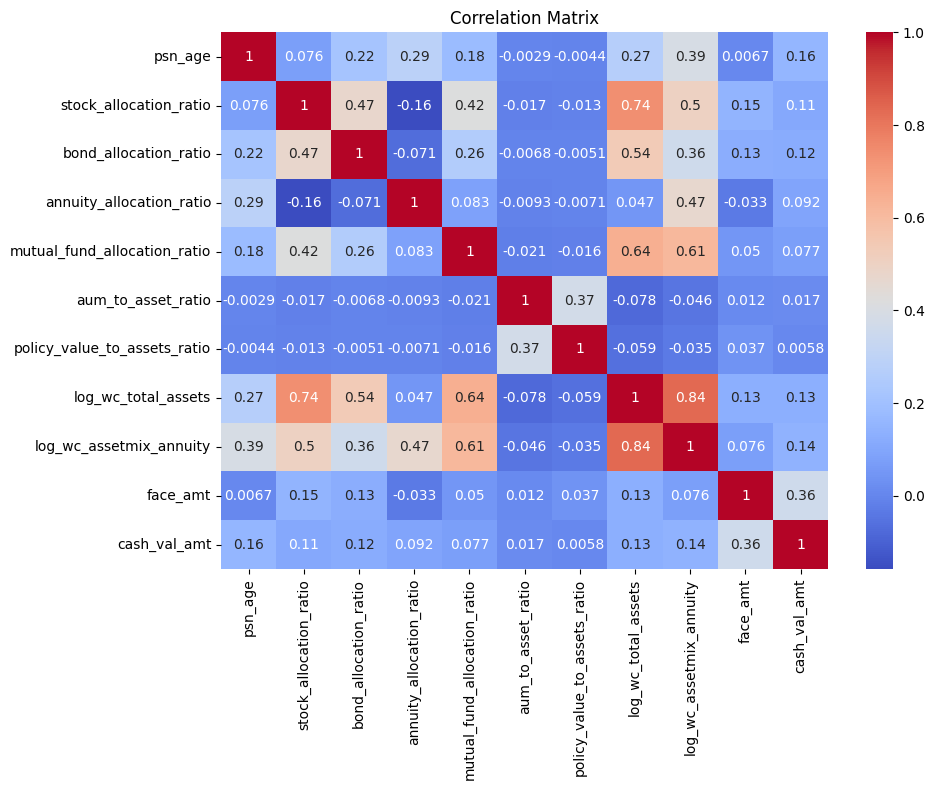

In [0]:
# Correlation matrix after removing highly correlated features

numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
exclude_cols = ['years_to_second', 'days_to_second', 'age_at_first_policy', 'age_at_second_policy', 'log_wc_assetmix_stocks', 'log_wc_assetmix_bonds', 'log_wc_assetmix_mutual_funds', 'log_wc_assetmix_deposits', 'log_wc_assetmix_other_assets']
numerical_features = [col for col in numerical_features if col not in exclude_cols and not col.startswith('wc')]

for col in ['face_amt', 'cash_val_amt']:
    if col in df.columns and col not in numerical_features:
        numerical_features = list(numerical_features) + [col]

corr_matrix = df[numerical_features].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
display(plt.gcf())
plt.close()

In [0]:
df.columns

Index(['axa_party_id', 'policy_no', 'register_date', 'trmn_eff_date',
       'wti_lob_txt', 'prod_lob', 'agt_class', 'isrd_brth_date', 'psn_age',
       'acct_val_amt', 'face_amt', 'cash_val_amt', 'wc_total_assets',
       'wc_assetmix_stocks', 'wc_assetmix_bonds', 'wc_assetmix_mutual_funds',
       'wc_assetmix_annuity', 'wc_assetmix_deposits',
       'wc_assetmix_other_assets', 'client_seg', 'client_seg_1', 'aum_band',
       'sub_product_level_1', 'sub_product_level_2', 'Product',
       'business_month', 'branchoffice_code', 'agt_no', 'division_name',
       'mkt_prod_hier', 'policy_status', 'channel', 'agent_segment',
       'second_policy_no', 'second_register_date', 'second_trmn_eff_date',
       'second_wti_lob_txt', 'second_prod_lob', 'second_sub_product_level_1',
       'second_sub_product_level_2', 'second_Product',
       'stock_allocation_ratio', 'bond_allocation_ratio',
       'annuity_allocation_ratio', 'mutual_fund_allocation_ratio',
       'aum_to_asset_ratio', 'policy

Medium Imputation performed for the numerical (ratio) columns - this ensures that all records are usable, improving training efficiency and accuracy.

In [0]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, Imputer
from pyspark.ml.classification import GBTClassifier, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from synapse.ml.lightgbm import LightGBMClassifier

# Median imputation for allocation ratio columns
allocation_cols = [
    'stock_allocation_ratio', 'bond_allocation_ratio', 'annuity_allocation_ratio',
    'mutual_fund_allocation_ratio', 'aum_to_asset_ratio', 'policy_value_to_assets_ratio'
]

if 'spark' not in globals() or spark is None:
    raise RuntimeError("Spark context is not available. Please run this cell in a Databricks notebook with an active cluster.")

if not hasattr(df, 'columns'):
    raise RuntimeError("df is not defined or not a pandas DataFrame.")

imputer = Imputer(
    inputCols=[c for c in allocation_cols if c in df.columns],
    outputCols=[c for c in allocation_cols if c in df.columns],
    strategy="median"
)
spark_df = spark.createDataFrame(df)
df_imputed = imputer.fit(spark_df).transform(spark_df)
spark_df = df_imputed
display(spark_df)

Function for adding Propensity features - we're creating propensity features using train data and adding them to train and unseen data


In [0]:
def add_propensity_features(df, lookup_prod, lookup_mode, lookup_agent, lookup_branch):
    df_with_features = df.withColumnRenamed("product_category", "prod_code")
    df_with_features = df_with_features.join(lookup_prod, on="prod_code", how="left")
    df_with_features = df_with_features.join(lookup_mode, on="prod_code", how="left")
    df_with_features = df_with_features.join(lookup_agent, on=["agt_no", "prod_code"], how="left")
    df_with_features = df_with_features.join(lookup_branch, on=["branchoffice_code", "prod_code"], how="left")
    df_with_features = df_with_features.na.fill(0, [
        "p1_cross_sell_popularity",
        "agent_p1_cross_sell_count",
        "branch_p1_cross_sell_count"
    ])
    df_with_features = df_with_features.na.fill("UNKNOWN", ["p1_most_common_next_prod"])
    df_with_features = df_with_features.withColumnRenamed("prod_code", "product_category")
    return df_with_features

Using rows with a second policy for training


In [0]:
log_financial_cols = [
    'log_wc_total_assets', 'log_wc_assetmix_annuity', 'log_wc_assetmix_other_assets',
    'log_face_amt', 'log_cash_val_amt'
]

# Train only on rows with second_product_category (i.e., with a second policy)
train_df = spark_df.filter(col("second_product_category").isNotNull())
for colname in ['age_at_first_policy', 'years_to_second'] + [col for col in log_financial_cols if col in df.columns]:
    train_df = train_df.filter(col(colname).isNotNull())

In [0]:
# Split train_df into training and validation sets
train_data, val_data = train_df.randomSplit([0.8, 0.2], seed=42)

In [0]:
# Defining a new df for creating propensity features

cross_sell_history_df = train_data.select(
    F.col("product_category").alias("first_prod_code"),
    F.col("second_product_category").alias("second_prod_code"),
    "agt_no",
    "branchoffice_code"
)

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:434)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$1(UsageLogging.scala:510)
	at com.databricks.logging.UsageLogging.executeThunkAndCaptureResultTags$1(UsageLogging.scala:616)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperationWithResultTags$4(UsageLogging.scala:643)
	at com.databricks.logging.AttributionContextTracing.$anonfun$withAttributionContext$1(AttributionContextTracing.scala:49)
	at com.databricks.logging.AttributionContext$.$anonfun$withValue$1(AttributionContext.scala:293)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(Attr

FEATURE ENGINEERING - PROPENSITY FEATURES
- Product propensity - Given product A was sold first, how likely is product B is to be sold next  --- Tells the global cross sell tendency
- Agent Propensity - How often does this agent sell product A and then any product B --- incorporates seller behavior and identifies agents with strong patterns
- Branch Propensity - How often does a specific branch sell product A and then product B --- captures branch influence


In [0]:
# Feature: Most common next product (mode)
prod_total_cross_sells = cross_sell_history_df.groupBy("first_prod_code") \
    .count() \
    .withColumnRenamed("count", "p1_total_cross_sells")
propensity_prod_df = prod_total_cross_sells.withColumnRenamed("first_prod_code", "prod_code") \
    .withColumnRenamed("p1_total_cross_sells", "p1_cross_sell_popularity")
display(propensity_prod_df)

path_counts = cross_sell_history_df.groupBy("first_prod_code", "second_prod_code").count()
window_spec = Window.partitionBy("first_prod_code").orderBy(F.col("count").desc())
most_common_path_df = path_counts.withColumn("rank", F.row_number().over(window_spec)) \
    .filter(F.col("rank") == 1) \
    .select(
        F.col("first_prod_code").alias("prod_code"),
        F.col("second_prod_code").alias("p1_most_common_next_prod")
    )
display(most_common_path_df)

# Feature: Agent-level cross-sell count
propensity_agent_df = cross_sell_history_df.groupBy("agt_no", "first_prod_code") \
    .count() \
    .withColumnRenamed("count", "agent_p1_cross_sell_count") \
    .withColumnRenamed("first_prod_code", "prod_code")
display(propensity_agent_df)

# Feature: Branch-level cross-sell count
propensity_branch_df = cross_sell_history_df.groupBy("branchoffice_code", "first_prod_code") \
    .count() \
    .withColumnRenamed("count", "branch_p1_cross_sell_count") \
    .withColumnRenamed("first_prod_code", "prod_code")
display(propensity_branch_df)

In [0]:
# Add propensity features to train and validation sets
train_df_final = add_propensity_features(
    train_data, propensity_prod_df, most_common_path_df, propensity_agent_df, propensity_branch_df
)
val_df_final = add_propensity_features(
    val_data, propensity_prod_df, most_common_path_df, propensity_agent_df, propensity_branch_df
)

Gather columns for training

In [0]:
#
# These features are not used in the model, but are used for validationIndicatorCol param in LightGBM ONLY
train_df_final = train_df_final.withColumn("is_validation", F.lit(False))
val_df_final = val_df_final.withColumn("is_validation", F.lit(True))
combined_train_val = train_df_final.unionByName(val_df_final)
#

# Define categorical columns (add p1_most_common_next_prod)
cat_cols = cat_cols + ['p1_most_common_next_prod']

# Define feature columns
feature_cols = (
    [f"{c}_idx" for c in cat_cols] +
    [
        'age_at_first_policy', 'years_to_second',
        'stock_allocation_ratio', 'bond_allocation_ratio', 'annuity_allocation_ratio',
        'mutual_fund_allocation_ratio', 'aum_to_asset_ratio', 'policy_value_to_assets_ratio'
    ] +
    [col for col in log_financial_cols if col in df.columns] +
    [
        "p1_cross_sell_popularity",
        "agent_p1_cross_sell_count",
        "branch_p1_cross_sell_count"
    ]
)

In [0]:
# Index categorical columns
indexers = [
    StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep")
    for c in cat_cols
]
label_indexer = StringIndexer(
    inputCol="second_product_category", outputCol="label", handleInvalid="keep"
)

assembler = VectorAssembler(
    inputCols=feature_cols, outputCol="features", handleInvalid="keep"
)

In [0]:
### GBT CLASSIFIER TRAINING

gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=50, maxDepth=5)
ovr = OneVsRest(classifier=gbt, labelCol="label", featuresCol="features")
pipeline_ovr = Pipeline(stages=indexers + [label_indexer, assembler, ovr])

model = pipeline_ovr.fit(train_df_final)

# Get feature importances from the first binary GBT model in OneVsRest
gbt_model = model.stages[-1].models[0]

The parameter 'isUnbalance' handles the class imbalance in LightGBM when set to _True_

In [0]:
### LIGHTGBM TRAINING

lgbm = LightGBMClassifier(
    labelCol="label",
    featuresCol="features",
    isUnbalance=True,
    validationIndicatorCol="is_validation"
)
lgbm.setParams(
    maxDepth=7,
    objective="multiclass",
    numClass=6,
    learningRate  =0.05,
    numIterations=1000,
    earlyStoppingRound=50,
    numLeaves=40,
    baggingFraction=0.8,
    baggingFreq=1,
    featureFraction=0.8
)

pipeline_ovr = Pipeline(stages=indexers + [label_indexer, assembler, lgbm])
model = pipeline_ovr.fit(combined_train_val)

# Get feature importances for LightGBM
gbt_model = model.stages[-1]

In [0]:
# FEATURE IMPORTANCE AND DISPLAY PREDICTED SECOND PRODUCT

importances = gbt_model.getFeatureImportances()
import pandas as pd
feature_importance = pd.DataFrame({
    "feature": feature_cols,
    "importance": importances.toArray()
}).sort_values("importance", ascending=False)
display(spark.createDataFrame(feature_importance))

predictions_val = model.transform(val_df_final)
from pyspark.ml.feature import IndexToString
label_converter = IndexToString(
    inputCol="prediction",
    outputCol="predicted_second_product_category",
    labels=model.stages[-3].labels
)
final_predictions = label_converter.transform(predictions_val)
display(final_predictions.select("axa_party_id", "policy_no", "product_category", "predicted_second_product_category"))

Storing the Propensity features in the catalog explorer for pipeline preprocessing

In [0]:
propensity_prod_df.write.format("delta").mode("overwrite").saveAsTable("eda_smartlist.us_wealth_management_smartlist.propensity_prod_df")

most_common_path_df.write.format("delta").mode("overwrite").saveAsTable("eda_smartlist.us_wealth_management_smartlist.most_common_path_df")

propensity_agent_df.write.format("delta").mode("overwrite").saveAsTable("eda_smartlist.us_wealth_management_smartlist.propensity_agent_df")

propensity_branch_df.write.format("delta").mode("overwrite").saveAsTable("eda_smartlist.us_wealth_management_smartlist.propensity_branch_df")

Registering the model in the catalog explorer

In [0]:
import mlflow
import mlflow.spark
from mlflow.models import infer_signature

# Get a sample input (as a pandas DataFrame)
input_example = train_df_final.limit(5).toPandas()

# Get model predictions for the sample input
predictions = model.transform(train_df_final.limit(5))
output_example = predictions.select("prediction").toPandas()

# Infer the signature
signature = infer_signature(input_example, output_example)

with mlflow.start_run():
    mlflow.spark.log_model(
        spark_model=model,
        artifact_path="gbt_propfeat_lightgbm",
        registered_model_name="eda_smartlist.models.gbt_propfeat_lightgbm",
        signature=signature,
        input_example=input_example
    )

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:132)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:132)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can

Evaluating the model performance using Accuracy, Precision, Recall and F1 score

In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# Overall metrics
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions_val)

evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1"
)
f1 = evaluator_f1.evaluate(predictions_val)

evaluator_precision = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedPrecision"
)
precision = evaluator_precision.evaluate(predictions_val)

evaluator_recall = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedRecall"
)
recall = evaluator_recall.evaluate(predictions_val)

metrics_df = spark.createDataFrame(
    [{"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}]
)
print("=" * 60)
print("OVERALL MODEL PERFORMANCE")
print("=" * 60)
display(metrics_df)

# Convert predictions to pandas for detailed analysis
pred_pandas = final_predictions.select("label", "prediction", "second_product_category", "predicted_second_product_category").toPandas()

# Get label mapping
label_mapping = {i: label for i, label in enumerate(model.stages[-3].labels)}

# Confusion Matrix
print("\n" + "=" * 60)
print("CONFUSION MATRIX")
print("=" * 60)
cm = confusion_matrix(pred_pandas['label'], pred_pandas['prediction'])
cm_df = pd.DataFrame(cm, 
                     index=[label_mapping.get(i, f'Class_{i}') for i in range(len(cm))],
                     columns=[label_mapping.get(i, f'Class_{i}') for i in range(len(cm))])
display(cm_df)

# Per-class metrics
print("\n" + "=" * 60)
print("PER-CLASS PERFORMANCE METRICS")
print("=" * 60)
report = classification_report(pred_pandas['label'], pred_pandas['prediction'], 
                               target_names=[label_mapping.get(i, f'Class_{i}') for i in range(len(label_mapping))],
                               output_dict=True)
report_df = pd.DataFrame(report).transpose()
display(report_df)

# Class distribution analysis
print("\n" + "=" * 60)
print("CLASS DISTRIBUTION IN VALIDATION SET")
print("=" * 60)
class_dist = pred_pandas['label'].value_counts().sort_index()
class_dist_df = pd.DataFrame({
    'Class': [label_mapping.get(i, f'Class_{i}') for i in class_dist.index],
    'Count': class_dist.values,
    'Percentage': (class_dist.values / len(pred_pandas) * 100).round(2)
})
display(class_dist_df)

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:434)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$1(UsageLogging.scala:510)
	at com.databricks.logging.UsageLogging.executeThunkAndCaptureResultTags$1(UsageLogging.scala:616)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperationWithResultTags$4(UsageLogging.scala:643)
	at com.databricks.logging.AttributionContextTracing.$anonfun$withAttributionContext$1(AttributionContextTracing.scala:49)
	at com.databricks.logging.AttributionContext$.$anonfun$withValue$1(AttributionContext.scala:293)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(Attr

### **STEP 1: COMPREHENSIVE DATA ANALYSIS FOR MODEL IMPROVEMENT**

Let's analyze the data systematically to identify improvement opportunities:
1. Class distribution and imbalance
2. Feature quality and distributions
3. Missing value patterns
4. Feature importance analysis
5. Error pattern analysis


In [ ]:
# ============================================================================
# ANALYSIS 1: CLASS DISTRIBUTION IN TRAINING DATA
# ============================================================================
print("=" * 70)
print("CLASS DISTRIBUTION ANALYSIS - TRAINING DATA")
print("=" * 70)

# Get class distribution in training set
train_class_dist = train_df_final.groupBy("second_product_category").count().orderBy(F.desc("count"))
train_class_dist_pd = train_class_dist.toPandas()
train_class_dist_pd['percentage'] = (train_class_dist_pd['count'] / train_class_dist_pd['count'].sum() * 100).round(2)
train_class_dist_pd.columns = ['Class', 'Count', 'Percentage']
print("\nTraining Set Class Distribution:")
display(train_class_dist_pd)

# Get class distribution in validation set
val_class_dist = val_df_final.groupBy("second_product_category").count().orderBy(F.desc("count"))
val_class_dist_pd = val_class_dist.toPandas()
val_class_dist_pd['percentage'] = (val_class_dist_pd['count'] / val_class_dist_pd['count'].sum() * 100).round(2)
val_class_dist_pd.columns = ['Class', 'Count', 'Percentage']
print("\nValidation Set Class Distribution:")
display(val_class_dist_pd)

# Calculate imbalance ratio
min_class = train_class_dist_pd['Count'].min()
max_class = train_class_dist_pd['Count'].max()
imbalance_ratio = max_class / min_class
print(f"\nClass Imbalance Ratio (max/min): {imbalance_ratio:.2f}")
print(f"Most common class: {train_class_dist_pd.iloc[0]['Class']} ({train_class_dist_pd.iloc[0]['Percentage']}%)")
print(f"Least common class: {train_class_dist_pd.iloc[-1]['Class']} ({train_class_dist_pd.iloc[-1]['Percentage']}%)")


In [ ]:
# ============================================================================
# ANALYSIS 2: MISSING VALUES ANALYSIS
# ============================================================================
print("=" * 70)
print("MISSING VALUES ANALYSIS")
print("=" * 70)

# Convert to pandas for easier analysis
train_pd = train_df_final.toPandas()

# Check missing values in key features
key_features = feature_cols + ['product_category', 'second_product_category', 'age_at_first_policy', 
                               'years_to_second', 'agt_no', 'branchoffice_code']
available_features = [f for f in key_features if f in train_pd.columns]

missing_analysis = []
for col in available_features:
    missing_count = train_pd[col].isna().sum()
    missing_pct = (missing_count / len(train_pd) * 100) if len(train_pd) > 0 else 0
    missing_analysis.append({
        'Feature': col,
        'Missing_Count': missing_count,
        'Missing_Percentage': round(missing_pct, 2),
        'Available_Count': len(train_pd) - missing_count
    })

missing_df = pd.DataFrame(missing_analysis).sort_values('Missing_Percentage', ascending=False)
print("\nMissing Values by Feature:")
display(missing_df[missing_df['Missing_Percentage'] > 0])

if len(missing_df[missing_df['Missing_Percentage'] > 0]) == 0:
    print("\n✓ No missing values found in key features!")
else:
    print(f"\n⚠ Found {len(missing_df[missing_df['Missing_Percentage'] > 0])} features with missing values")


In [ ]:
# ============================================================================
# ANALYSIS 3: FEATURE DISTRIBUTION AND OUTLIER ANALYSIS
# ============================================================================
print("=" * 70)
print("NUMERICAL FEATURE DISTRIBUTION ANALYSIS")
print("=" * 70)

import matplotlib.pyplot as plt
import seaborn as sns

# Select numerical features
numerical_cols = ['age_at_first_policy', 'years_to_second'] + \
                 [col for col in ['stock_allocation_ratio', 'bond_allocation_ratio', 
                                  'annuity_allocation_ratio', 'mutual_fund_allocation_ratio',
                                  'aum_to_asset_ratio', 'policy_value_to_assets_ratio'] 
                  if col in train_pd.columns] + \
                 [col for col in log_financial_cols if col in train_pd.columns] + \
                 ['p1_cross_sell_popularity', 'agent_p1_cross_sell_count', 'branch_p1_cross_sell_count']

available_numerical = [col for col in numerical_cols if col in train_pd.columns]

# Statistical summary
stats_summary = train_pd[available_numerical].describe()
print("\nStatistical Summary of Numerical Features:")
display(stats_summary)

# Check for outliers using IQR method
outlier_analysis = []
for col in available_numerical:
    Q1 = train_pd[col].quantile(0.25)
    Q3 = train_pd[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = train_pd[(train_pd[col] < lower_bound) | (train_pd[col] > upper_bound)]
    outlier_count = len(outliers)
    outlier_pct = (outlier_count / len(train_pd) * 100) if len(train_pd) > 0 else 0
    
    outlier_analysis.append({
        'Feature': col,
        'Outlier_Count': outlier_count,
        'Outlier_Percentage': round(outlier_pct, 2),
        'Min': round(train_pd[col].min(), 2),
        'Q1': round(Q1, 2),
        'Median': round(train_pd[col].median(), 2),
        'Q3': round(Q3, 2),
        'Max': round(train_pd[col].max(), 2)
    })

outlier_df = pd.DataFrame(outlier_analysis).sort_values('Outlier_Percentage', ascending=False)
print("\nOutlier Analysis (IQR Method):")
display(outlier_df)


In [ ]:
# ============================================================================
# ANALYSIS 4: FEATURE IMPORTANCE ANALYSIS
# ============================================================================
print("=" * 70)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 70)

# Get feature importances from the model
importances = gbt_model.getFeatureImportances()
feature_importance = pd.DataFrame({
    "feature": feature_cols,
    "importance": importances.toArray()
}).sort_values("importance", ascending=False)

print("\nTop 20 Most Important Features:")
display(feature_importance.head(20))

print("\nBottom 10 Least Important Features:")
display(feature_importance.tail(10))

# Calculate cumulative importance
feature_importance['cumulative_importance'] = feature_importance['importance'].cumsum()
feature_importance['cumulative_pct'] = (feature_importance['cumulative_importance'] / 
                                        feature_importance['importance'].sum() * 100)

# Find how many features account for 80% of importance
features_for_80pct = len(feature_importance[feature_importance['cumulative_pct'] <= 80])
print(f"\nNumber of features accounting for 80% of importance: {features_for_80pct} out of {len(feature_importance)}")
print(f"Percentage of features needed: {(features_for_80pct/len(feature_importance)*100):.1f}%")


In [ ]:
# ============================================================================
# ANALYSIS 5: ERROR PATTERN ANALYSIS
# ============================================================================
print("=" * 70)
print("ERROR PATTERN ANALYSIS - WHERE IS THE MODEL FAILING?")
print("=" * 70)

# Analyze misclassifications
pred_pandas['is_correct'] = pred_pandas['label'] == pred_pandas['prediction']
misclassified = pred_pandas[~pred_pandas['is_correct']].copy()

print(f"\nTotal predictions: {len(pred_pandas)}")
print(f"Correct predictions: {pred_pandas['is_correct'].sum()}")
print(f"Misclassified: {len(misclassified)} ({len(misclassified)/len(pred_pandas)*100:.2f}%)")

# Most common misclassification patterns
if len(misclassified) > 0:
    misclassified['actual'] = misclassified['label'].map(label_mapping)
    misclassified['predicted'] = misclassified['prediction'].map(label_mapping)
    
    error_patterns = misclassified.groupby(['actual', 'predicted']).size().reset_index(name='count')
    error_patterns = error_patterns.sort_values('count', ascending=False)
    error_patterns.columns = ['Actual_Class', 'Predicted_Class', 'Error_Count']
    
    print("\nTop 10 Most Common Misclassification Patterns:")
    display(error_patterns.head(10))
    
    # Analyze which classes are most confused
    print("\nClasses Most Often Confused (Actual -> Predicted):")
    confusion_summary = error_patterns.groupby('Actual_Class')['Error_Count'].sum().sort_values(ascending=False)
    confusion_summary_df = pd.DataFrame({
        'Actual_Class': confusion_summary.index,
        'Total_Errors': confusion_summary.values
    })
    display(confusion_summary_df)
else:
    print("\n✓ No misclassifications found!")


In [ ]:
# ============================================================================
# ANALYSIS 6: CROSS-SELL PATTERN ANALYSIS
# ============================================================================
print("=" * 70)
print("CROSS-SELL PATTERN ANALYSIS")
print("=" * 70)

# Analyze actual cross-sell patterns in training data
cross_sell_patterns = train_pd.groupby(['product_category', 'second_product_category']).size().reset_index(name='count')
cross_sell_patterns = cross_sell_patterns.sort_values('count', ascending=False)
cross_sell_patterns.columns = ['First_Product', 'Second_Product', 'Count']
cross_sell_patterns['Percentage'] = (cross_sell_patterns['Count'] / cross_sell_patterns['Count'].sum() * 100).round(2)

print("\nTop 20 Most Common Cross-Sell Patterns:")
display(cross_sell_patterns.head(20))

# Create a pivot table for better visualization
pivot_table = cross_sell_patterns.pivot_table(
    index='First_Product', 
    columns='Second_Product', 
    values='Count', 
    fill_value=0
)

print("\nCross-Sell Pattern Matrix (First Product -> Second Product):")
display(pivot_table)

# Calculate transition probabilities
transition_probs = train_pd.groupby('product_category')['second_product_category'].apply(
    lambda x: x.value_counts(normalize=True)
).reset_index()
transition_probs.columns = ['First_Product', 'Second_Product', 'Probability']
transition_probs = transition_probs.sort_values(['First_Product', 'Probability'], ascending=[True, False])

print("\nTop 3 Most Likely Next Products for Each First Product:")
for first_prod in transition_probs['First_Product'].unique():
    top3 = transition_probs[transition_probs['First_Product'] == first_prod].head(3)
    print(f"\n{first_prod}:")
    for _, row in top3.iterrows():
        print(f"  -> {row['Second_Product']}: {row['Probability']*100:.1f}%")


### **STEP 2: IDENTIFYING IMPROVEMENT OPPORTUNITIES**

Based on the analysis above, we'll identify specific areas for improvement:
1. **Class Imbalance Handling**: If severe imbalance exists, we may need SMOTE, class weights, or different sampling
2. **Feature Engineering**: Create new features based on patterns discovered
3. **Hyperparameter Tuning**: Optimize model parameters
4. **Ensemble Methods**: Combine multiple models
5. **Feature Selection**: Remove low-importance features or add domain-specific features


In [ ]:
# ============================================================================
# SUMMARY OF FINDINGS AND RECOMMENDATIONS
# ============================================================================
print("=" * 70)
print("SUMMARY OF FINDINGS")
print("=" * 70)

findings = []

# Check class imbalance
if 'imbalance_ratio' in locals():
    if imbalance_ratio > 5:
        findings.append({
            'Issue': 'Severe Class Imbalance',
            'Severity': 'HIGH',
            'Impact': 'Model may be biased toward majority class',
            'Recommendation': 'Use class weights, SMOTE, or stratified sampling'
        })
    elif imbalance_ratio > 2:
        findings.append({
            'Issue': 'Moderate Class Imbalance',
            'Severity': 'MEDIUM',
            'Impact': 'Minority classes may have lower recall',
            'Recommendation': 'Consider class weights or balanced sampling'
        })

# Check missing values
if 'missing_df' in locals() and len(missing_df[missing_df['Missing_Percentage'] > 5]) > 0:
    high_missing = missing_df[missing_df['Missing_Percentage'] > 5]
    findings.append({
        'Issue': f'High Missing Values in {len(high_missing)} features',
        'Severity': 'MEDIUM',
        'Impact': 'May reduce model performance',
        'Recommendation': 'Improve imputation strategy or feature engineering'
    })

# Check feature importance distribution
if 'feature_importance' in locals():
    low_importance_features = len(feature_importance[feature_importance['importance'] < 0.001])
    if low_importance_features > 5:
        findings.append({
            'Issue': f'{low_importance_features} features with very low importance',
            'Severity': 'LOW',
            'Impact': 'Noise in model, potential overfitting',
            'Recommendation': 'Consider feature selection to remove low-importance features'
        })

if findings:
    findings_df = pd.DataFrame(findings)
    display(findings_df)
else:
    print("\n✓ No major issues identified in initial analysis!")
    print("Focus areas: Feature engineering and hyperparameter tuning")

print("\n" + "=" * 70)
print("NEXT STEPS")
print("=" * 70)
print("1. Review all analysis outputs above")
print("2. Identify specific improvement strategies based on findings")
print("3. Implement improvements incrementally")
print("4. Measure impact of each change")
print("5. Iterate until F1 > 0.85 is achieved")


---

## **IMPROVEMENT ROADMAP: F1 Score 0.71 → >0.85**

### **Phase 1: Data Understanding (COMPLETED) ✅**
We've added comprehensive analysis cells that will help us understand:
- Current model performance (confusion matrix, per-class metrics)
- Class distribution and imbalance
- Feature quality and distributions
- Missing value patterns
- Feature importance
- Error patterns
- Cross-sell patterns

### **Phase 2: Run Analysis & Review Results (NEXT)**
1. Execute all analysis cells (cells 42-51)
2. Review findings and identify specific issues
3. Document insights from each analysis

### **Phase 3: Targeted Improvements (Based on Findings)**
Potential improvement strategies (to be prioritized based on analysis):

#### **A. Handle Class Imbalance**
- Use class weights in LightGBM
- Implement SMOTE or other oversampling techniques
- Use stratified sampling for train/val split

#### **B. Feature Engineering**
- Create interaction features (e.g., age × product_category)
- Add temporal features (month, day of week, time since first policy)
- Create aggregated features (agent performance, branch performance)
- Add product transition probability features
- Create client lifetime value features

#### **C. Model Improvements**
- Hyperparameter tuning with Optuna/Hyperopt
- Try different algorithms (XGBoost, CatBoost)
- Ensemble multiple models
- Use stacking or voting classifiers

#### **D. Data Quality**
- Better outlier handling
- Improved imputation strategies
- Feature selection (remove low-importance features)

### **Phase 4: Iterative Improvement**
- Implement one improvement at a time
- Measure impact on F1 score
- Keep improvements that help
- Remove changes that don't help

---

**Let's start by running the analysis cells to understand what we're working with!**


In [0]:
# register and create an alias for gbt model (log_model is already done after the training)

from mlflow import MlflowClient

client = MlflowClient()
model_name = "eda_smartlist.models.gbt_propfeat_lightgbm"
model_version = "1"  
alias = "gbt_propfeat_lgbm"

client.set_registered_model_alias(
    name=model_name,
    alias=alias,
    version=model_version
)

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:434)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$1(UsageLogging.scala:510)
	at com.databricks.logging.UsageLogging.executeThunkAndCaptureResultTags$1(UsageLogging.scala:616)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperationWithResultTags$4(UsageLogging.scala:643)
	at com.databricks.logging.AttributionContextTracing.$anonfun$withAttributionContext$1(AttributionContextTracing.scala:49)
	at com.databricks.logging.AttributionContext$.$anonfun$withValue$1(AttributionContext.scala:293)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(Attr

Hyperparameter tuning for GBT

In [0]:
# You cannot perform hyperparameter tuning directly on a saved model from Unity Catalog (eda_smartlist.models).
# Hyperparameter tuning (e.g., with CrossValidator) requires the original estimator (pipeline), not a fitted model.
# You must reconstruct the pipeline/estimator and perform tuning on it, not on the already saved model.

# Example: Hyperparameter tuning must be done as below, using the pipeline/estimator (not a loaded model)
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Define param grid
param_grid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 7, 10]) \
    .addGrid(gbt.maxIter, [50, 100, 200]) \
    .addGrid(gbt.stepSize, [0.05, 0.1]) \
    .addGrid(gbt.subsamplingRate, [0.7, 0.9]) \
    .addGrid(gbt.minInstancesPerNode, [1, 5, 10]) \
    .build()

# CrossValidator
cv = CrossValidator(
    estimator=pipeline_ovr,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=3,
    parallelism=10
)

# Fit model
cv_model = cv.fit(train_df_final)

# Evaluate best model
predictions_cv = cv_model.transform(val_df_final)

metrics_cv = {
    "accuracy": evaluator.evaluate(predictions_cv),
    "f1": MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1").evaluate(predictions_cv),
    "precision": MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision").evaluate(predictions_cv),
    "recall": MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall").evaluate(predictions_cv),
}

metrics_cv_df = spark.createDataFrame([metrics_cv])
display(metrics_cv_df)

In [0]:
# Load best model from hyperparameter tuning

best_model = cv_model.bestModel

gbt_model = best_model.stages[-1].models[0]
print("Best maxDepth:", gbt_model.getOrDefault("maxDepth"))
print("Best maxIter:", gbt_model.getOrDefault("maxIter"))

### **Next Steps**
### 
1. Train LightGBM
2. Train XGBoost
3. Hyperparameter Tuning using Hperopt